# Notebook for Exploring Explainable AI in a Physics Setting

In this notebook we explore how SHAP explainability deals with a physical system like the Duffing Oscillator

In [1]:
"""
Import Libraries
"""
# General Libraries
import numpy as np
import pandas as pd
import os

# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras


# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns

# Explainability
import lime
import shap

# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [2]:
"""
Choose the training data set to be trained on.

For general datasets use custom suffix.
"""
suffix = "mac_lots"#"delta03_irrelevant"#"delayed_traj_delta03"

train = True

X_train = pd.read_csv("Data/X_train_"+suffix+".csv", header=0, index_col=0)
y_train = pd.read_csv("Data/y_train_"+suffix+".csv", header=0, index_col=0)
X_test = pd.read_csv("Data/X_test_"+suffix+".csv", header=0, index_col=0)
y_test = pd.read_csv("Data/y_test_"+suffix+".csv", header=0, index_col=0)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [3]:
"""
f, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))

sns.scatterplot(data = y_test.iloc[:10000,:], x = 'xt', y='vt', ax=axs, marker='x', linewidth = 1)

axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x [ ]')
axs.set_ylabel('v [ ]')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("Images/data_only_"+suffix+".svg", dpi='figure')

f, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))

sns.scatterplot(data = X_test.iloc[:10000,:], x = 'x0', y='v0', ax=axs, marker='x', linewidth = 1)
axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x [ ]')
axs.set_ylabel('v [ ]')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("Images/data_only_"+suffix+".svg", dpi='figure')
"""

'\nf, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))\n\nsns.scatterplot(data = y_test.iloc[:10000,:], x = \'xt\', y=\'vt\', ax=axs, marker=\'x\', linewidth = 1)\n\naxs.set(xlim=(-2, 2), ylim=(-2, 2))\naxs.set_xlabel(\'x [ ]\')\naxs.set_ylabel(\'v [ ]\')\naxs.set_title("Phase Space Plot")\n\nf.tight_layout()\n\nf.savefig("Images/data_only_"+suffix+".svg", dpi=\'figure\')\n\nf, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))\n\nsns.scatterplot(data = X_test.iloc[:10000,:], x = \'x0\', y=\'v0\', ax=axs, marker=\'x\', linewidth = 1)\naxs.set(xlim=(-2, 2), ylim=(-2, 2))\naxs.set_xlabel(\'x [ ]\')\naxs.set_ylabel(\'v [ ]\')\naxs.set_title("Phase Space Plot")\n\nf.tight_layout()\n\nf.savefig("Images/data_only_"+suffix+".svg", dpi=\'figure\')\n'

## Preprocess

Optional data preprocessing step, fourier transform.

Scale the data to 0 mean and unit variance, this is mainly done to improve the neural network's performance but also ensures that magnitude differences between the features have no impact on explainability.

In [4]:
"""
from scipy.fft import fft, fftfreq, fftshift


fft(X_test.values)

t = np.arange(250)

sp = fftshift(fft(X_test.values[:250,:]))

freq = fftshift(fftfreq(t.shape[-1]))

plt.plot(freq, sp.real, freq, sp.imag, 'x')

plt.show()
"""

"\nfrom scipy.fft import fft, fftfreq, fftshift\n\n\nfft(X_test.values)\n\nt = np.arange(250)\n\nsp = fftshift(fft(X_test.values[:250,:]))\n\nfreq = fftshift(fftfreq(t.shape[-1]))\n\nplt.plot(freq, sp.real, freq, sp.imag, 'x')\n\nplt.show()\n"

In [5]:
scaler = StandardScaler()

scaler.fit(X_train.values)
scaler.transform(X_train.values, copy=False)
scaler.transform(X_test.values, copy = False)

#anova_svm = make_pipeline(scaler, model)
#anova_svm.fit(X_train, y_train)

array([[-1.46476691, -0.15646806, -0.52950641],
       [-1.08962127,  0.54608022, -0.12767396],
       [ 0.42444954,  0.3075383 , -0.18309912],
       ...,
       [-0.19980822, -1.30346423,  0.37115253],
       [ 1.55915821,  1.11694855,  1.56972175],
       [ 1.43625866,  1.60450129, -1.52023125]])

## Network Training

Here we set up the neural network. We are using a large batch size (5096) to speed up training. Data are shuffled before training because we are using a method to generate the data that causes codependence in adjacent training samples as they belong to the same trajectory. Early stopping criteria are there to stop overfitting though this has rarely been a problem in this setting.

The network architecture makes use of a lot of dense (fully connected) layers. This leads to a large number of trainable parameters so care should be taken to ensure that the dataset is large enough to prevent overfitting being a viable strategy.

As a validation set we use 20% of the training data.

We make use of the Adam optimiser. Using a learning rate of 0.001 seems to work, greater learning rates cause the network to not learn at all and a smaller learning rate slows learning unnecessarily.

In [6]:
"""
Define and Create Model
"""

def MLModel():
    opt = Adam(learning_rate=0.001, beta_1=0.7)
    loss='mse'
    model = Sequential([
        layers.Flatten(),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='tanh'),
        layers.Dense(2)            
    ])
    model.compile(optimizer=opt, loss=loss)
    return model

# Create a basic model instance
model = MLModel()

In [7]:
# Model Weights Path
checkpoint_path = "Networks/training"+suffix+"cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [8]:
"""
Train Model
"""
#model.build()
# Display the model's architecture
#model.summary()


if train:
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    callbacks = [cp_callback,
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
                 tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)]

    pipe = make_pipeline(scaler, model)

    history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=500, 
                      validation_split=0.2, batch_size=20364, shuffle=True, callbacks=callbacks, verbose=1)

    loss = model.evaluate(X_test, y_test, verbose=1)
    print("Trained model, loss: {:5.2f}%".format(loss))

Epoch 1/500
393/393 [==============================] - 51s 127ms/step - loss: 0.3810 - val_loss: 0.3034

Epoch 00001: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 2/500
393/393 [==============================] - 50s 127ms/step - loss: 0.2749 - val_loss: 0.2398

Epoch 00002: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 3/500
393/393 [==============================] - 50s 127ms/step - loss: 0.2314 - val_loss: 0.2286

Epoch 00003: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 4/500
393/393 [==============================] - 50s 126ms/step - loss: 0.2098 - val_loss: 0.2153

Epoch 00004: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 5/500
393/393 [==============================] - 50s 127ms/step - loss: 0.1980 - val_loss: 0.1962

Epoch 00005: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 6/500
393/393 [==============================] - 50s 127ms/step - loss: 0.1907 - val_loss: 0.1840

Epoch 00006: saving model to Networks\trainingmac_lotsc


Epoch 00049: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 50/500
393/393 [==============================] - 50s 127ms/step - loss: 0.1364 - val_loss: 0.1383

Epoch 00050: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 51/500
393/393 [==============================] - 49s 126ms/step - loss: 0.1362 - val_loss: 0.1345

Epoch 00051: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 52/500
393/393 [==============================] - 49s 126ms/step - loss: 0.1357 - val_loss: 0.1374

Epoch 00052: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 53/500
393/393 [==============================] - 49s 126ms/step - loss: 0.1351 - val_loss: 0.1374

Epoch 00053: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 54/500
393/393 [==============================] - 50s 126ms/step - loss: 0.1352 - val_loss: 0.1347

Epoch 00054: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 55/500
393/393 [==============================] - 50s 126ms/step - loss: 0.1343 - val

In [9]:
"""
Load Model
"""
if not train:
    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=2)
    print("Untrained model, loss: {:5.2f}%".format(loss))

    # Loads the weights
    model.load_weights(checkpoint_path)

    # Re-evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=1)
    print("Trained model, loss: {:5.2f}%".format(loss))

In [10]:
class TrueModel():
    """
    Class to represent the True Model of the Duffing oscillator.
    Uses the scipy odeint integrator to perform time evolution.
    
    Methods:
    -----------
    predict(X):
        Inputs:
        --------
        X: pandas DataFrame with at least columns x0,v0,t
        Returns:
        --------
        y: pandas DataFrame with columns xt,vt
    """
    def __init__(self, scaler, X):
        self.alpha=-1
        self.beta=1
        self.delta=0.3
        self.gamma=0.37
        self.omega=1.2
        self.scaler = scaler
        self.cols = X.columns
        
    def eom(self, u, t):
        x, dx = u[0], u[1]
        ddx= self.gamma * np.cos(self.omega * t) - (self.delta * dx + self.alpha*x + self.beta * x**3)
        return [dx,ddx]
    
    def predict(self, X):
        X = pd.DataFrame(self.scaler.inverse_transform(X), columns=self.cols)
        y = np.ones((np.shape(X)[0], 2))
        for i in range(0,np.shape(X)[0]):
            t_range = np.linspace(0, X['t'].iloc[i], 500, endpoint=False)
            y[i,:] = odeint(self.eom, [X['x0'].iloc[i],X['v0'].iloc[i]], t_range)[-1]
        #y = pd.DataFrame(y, columns=['xt','vt'])    
        return y


## Evaluation and Visualisation of Results:

To be able to visualise the error we remove outliers (top 5% of absolute error). This ensures that the rare misclassifications don't drag the x-axis of our error plot out too far.



In [ ]:
# evaluate the fitting validation and training losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

## Make Prdictions on the Test Dataset
y_pred = pd.DataFrame(model.predict(X_test), columns=['xt','vt'])

pred_norm = np.linalg.norm(y_pred[['xt','vt']].values,axis=1)
true_norm = np.linalg.norm(y_test[['xt','vt']].values,axis=1)
hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
hist_data = pd.DataFrame(hist_data, columns=['norm'])

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.00)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df > (Q3 + 1.5 * IQR)))
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

indices = Remove_Outlier_Indices(hist_data)
hist_data = hist_data[indices]

In [ ]:
# Loss Plot ML Model
f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.lineplot(data = history.history, x = epochs, y='loss',ax=axs[0,0], label='loss')
sns.lineplot(data = history.history, x = epochs, y='val_loss',ax=axs[0,0], label='val_loss')

axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("Losses by Epoch")
axs[0,0].legend()

# Error Plot for ML Predictions
sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.01, ax=axs[0,1])

axs[0,1].set(xlim=(0, 0.6), ylim=(0, 0.4))
axs[0,1].set_xlabel('Error')
axs[0,1].set_ylabel('Probability')
axs[0,1].set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$")

# True Values Plot
sns.scatterplot(data = y_test.iloc[:2000,:], x = 'xt', y='vt',ax=axs[1,0],label='true_values', marker='x', linewidth = 1)

axs[1,0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,0].set_xlabel('x [ ]')
axs[1,0].set_ylabel('v [ ]')
axs[1,0].set_title("Phase Space Plot (True Model)")

# ML Values Plot
sns.scatterplot(data = y_pred.iloc[:2000,:], x='xt', y='vt',ax=axs[1,1],label='pred_values',  marker='x', linewidth = 1)

axs[1,1].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,1].set_xlabel('x [ ]')
axs[1,1].set_ylabel('v [ ]')
axs[1,1].set_title("Phase Space Plot (ML Model)")

f.tight_layout()

f.savefig("Images/model_summary"+suffix+".svg", dpi='figure')

### Ordered 

Lets choose a spectrum of values that have similar v0 and t whilst x0 varies from -2 to 2:


## Good Values
Only looking at good predictions: $|y_{pred}-y_{true}| < 0.1$

In [50]:
"""
Explainers: Here we create the explainer object and evaluate it on a number of samples
tol: Tolerance for y_pred-y_true
num_vals: Number of values to evaluate the explainers on. Use minimum of num_vals and number of samples available

"""

class wilke_explainer():
    """
    models: dict {mod_name: model} where model implements a predict function that outputs a numpy array.
    """
    def __init__(self, models, background_data, test_data, test_labels, data_tol=0.1, num_vals=100, 
                 explainer_type='shap', background_resolution=100, tolerance=0.1):
        self.num_vals = num_vals
        self.tol = data_tol
        self.models = models
        self.background_data = background_data
        self.test_data = test_data
        self.test_labels = test_labels
        self.tolerance = tolerance
        self.explainers = {}
        self.background = shap.sample(self.background_data, background_resolution)
        self.explainer_type = explainer_type
        if explainer_type=='shap':
             for mod in models:
                self.explainers[mod] = shap.KernelExplainer((models[mod]).predict, self.background)
        if explainer_type=='lime':
             for mod in models:
                self.explainers[mod] = shap.LimeTabular((models[mod]).predict, background_resolution)
    
    def choose_data(self, i, feature, num_features):
        vals = np.abs(np.linalg.norm((self.models['ml']).predict(self.test_data), axis=1) - 
                      np.linalg.norm(self.test_labels, axis=1))
        data_arr = self.test_data.iloc[np.where(vals < self.tolerance)]
        where__ = np.ones_like(data_arr.values[:,i], dtype=bool)
        for j in range(1,num_features):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%num_features])<self.tol)
        data_arr = data_arr.iloc[where__]
        data_arr = data_arr.iloc[np.sort(
            np.random.choice(data_arr.shape[0], np.min([self.num_vals, data_arr.shape[0]]), replace=False))]
        return data_arr
        
    def eval_explainer(self):
        first_run = True
        for i, __feature in enumerate(self.test_data.columns):
            arr = self.choose_data(i, __feature, len(self.test_data.columns))
            for __explainer in self.explainers:
                if self.explainer_type=='shap':
                    __atts = self.explainers[__explainer].shap_values(arr)
                if self.explainer_type=='lime':
                    __atts = self.explainers[__explainer].attributions(arr)
                    
                for j, __contribution in enumerate(self.test_labels.columns):
                    multi_index = [range(len(arr)), [__feature for i in range(len(arr))], 
                                   [__contribution for i in range(len(arr))],
                                   [__explainer for i in range(len(arr))]]
                    if first_run:
                        self.feature_attributions = pd.DataFrame(__atts[j], 
                                                                 columns = self.test_data.columns, 
                                                                 index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('num', 'feature', 'contribution', 'model')))
                    else:
                        self.feature_attributions = self.feature_attributions.append(pd.DataFrame(__atts[j], 
                                                                 columns = self.test_data.columns, 
                                                                 index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('num', 'feature', 'contribution', 'model'))))
                    first_run = False
                    
        return self.feature_attributions
        
    def exp_plot(self):
        f, axs = plt.subplots(self.test_labels.shape[1], self.test_data.shape[1], 
                              figsize=(4*self.test_data.shape[1], 8), 
                              gridspec_kw=dict(width_ratios=4*np.ones((self.test_data.shape[1]))))

        for i, __feature in enumerate(self.test_data.columns):
            for j, __contribution in enumerate(self.test_labels.columns):
                for __model in self.models:
                    sns.scatterplot(data = self.feature_attributions.xs((__feature, __contribution, __model), 
                                                      level=('feature', 'contribution', 'model')), 
                                    x = self.feature_attributions.xs((__feature, __contribution, 'true'), 
                                                   level=('feature', 'contribution', 'model')).index,
                                    y=self.feature_attributions.xs((__feature, __contribution, __model), 
                                                 level=('feature', 'contribution', 'model'))[__feature],
                                    label = __model, ax=axs[j,i])  
                    
                axs[j,i].set_title(r"Feature Contribution of "+feature+" to "+contribution+"")
                axs[j,i].set_xlabel('Index [ ]')
                axs[j,i].set_ylabel('Feature Contribution [ ]')

        f.tight_layout()

        f.savefig("Images/shap_summary"+suffix+"_kernel_good.svg", dpi='figure')
    
    def agg_func(X):
        return np.mean(np.abs(X))
    
    def aggregate(self):       
        self.agg_vals = np.zeros((len(self.test_labels.columns),len(self.models)))
        
        for i, __contribution in enumerate(self.test_labels.columns):
            for j, __model in enumerate(self.models):
                for k, __feature in enumerate(self.test_data.columns):
                    self.agg_vals[i,j] = self.agg_func(
                        self.feature_attributions.xs((__feature,
                                                      __contribution,
                                                      __model), level=('feature', 'contribution', 'model'))[__feature])

        self.agg_vals = pd.DataFrame(self.agg_vals, columns = self.test_labels.columns, index = self.test_data.columns)
        return self.agg_vals
    
    def agg_plot(self):
        f, axs = plt.subplots(len(self.models), self.test_labels.shape[1], 
                              figsize=(4*self.test_labels.shape[1], 4*len(self.models)), 
                              gridspec_kw=dict(width_ratios=4*np.ones((self.test_labels.shape[1]))))
        
        for i, __model in enumerate(self.models):
            for j, __contribution in enumerate(self.test_labels):
                sns.barplot(data = self.agg_vals, x = self.agg_vals.index,
                            y = __contribution, label = contribution, ax=axs[i,j])
                axs[i,j].set_title(r"Aggregate Feature Contribution to "+__contribution+" in the "+__model+" Model")
                axs[i,j].set_ylabel('Feature Contribution [ ]')

        f.tight_layout()
        f.savefig("Images/shap_aggregated"+suffix+".svg", dpi='figure')

In [51]:
true_model = TrueModel(scaler, X_test)

models = {'ml': model, 
         'true': true_model}

explainer = wilke_explainer(models, X_train, X_test, y_test)

In [ ]:
explainer_data = explainer.eval_explainer()

explainer.exp_plot()

explainer_agg = explainer.aggregate()

explainer.agg_plot()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Initialise True Model
true_model = TrueModel(scaler, X_test)

# Choose Background Samples for the Explainer to use for averaging out features
background = shap.sample(X_train, 200)

# Initialise Explainers
explainer_model = shap.KernelExplainer(model.predict, background)
explainer_true = shap.KernelExplainer(true_model.predict, background)

# Define Parameters
tol = 0.1
vals = np.abs(np.linalg.norm(model.predict(X_test), axis=1)- np.linalg.norm(y_test, axis=1))
num_vals = 100

X_test_good = X_test.iloc[np.where(vals < tol)]

counter = 0
for i, feature in enumerate(X_test.columns):
    arr = X_test_good.sort_values(by=feature).iloc[np.where(np.multiply(np.abs(X_test_good.values[:,(i+1)%3])<0.1, 
                                                                        np.abs(X_test_good.values[:,(i+2)%3]<0.1)))]
    arr = arr.iloc[np.sort(np.random.choice(arr.shape[0], np.min([num_vals,arr.shape[0]]) , replace=False))]
    true_arr = explainer_true.shap_values(arr)
    ml_arr = explainer_model.shap_values(arr)

    for j, contribution in enumerate(y_test.columns):
        print(counter)
        arrays_true = [range(num_vals), [feature for i in range(num_vals)], [contribution for i in range(num_vals)],
                 ['true' for i in range(num_vals)]]
        arrays_ml = [range(num_vals), [feature for i in range(num_vals)], [contribution for i in range(num_vals)],
                 ['ml' for i in range(num_vals)]]
        if counter==0:
            shap_df = pd.DataFrame(true_arr[j], columns = X_test.columns, index = pd.MultiIndex.from_arrays(arrays_true, names=('num', 'feature', 'contribution', 'model')))
        else:
            shap_df = shap_df.append(pd.DataFrame(true_arr[j], columns = X_test.columns,index = pd.MultiIndex.from_arrays(arrays_true, names=('num', 'feature', 'contribution', 'model'))))
        shap_df = shap_df.append(pd.DataFrame(ml_arr[j], columns = X_test.columns, index = pd.MultiIndex.from_arrays(arrays_ml, names=('num', 'feature', 'contribution', 'model'))))
        counter+=1
            

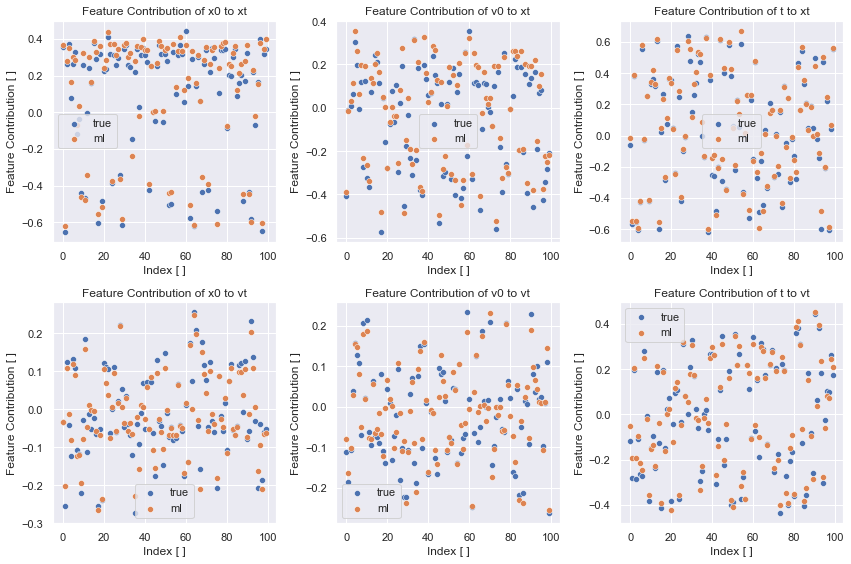

In [38]:
f, axs = plt.subplots(2, X_test.shape[1], figsize=(4*X_test.shape[1], 8), gridspec_kw=dict(width_ratios=4*np.ones((X_test.shape[1]))))#[4, 4, 4, 4]))

shap_df = testing
for i, feature in enumerate(X_test.columns):
    for j, contribution in enumerate(y_test.columns):
        for model_ in ['true','ml']:
            sns.scatterplot(data = shap_df.xs((feature, contribution, 'true'), level=('feature', 'contribution', 'model')), x = shap_df.xs((feature, contribution, 'true'), level=('feature', 'contribution', 'model')).index,
                        y=shap_df.xs((feature, contribution, model_), level=('feature', 'contribution', 'model'))[feature],
                        label = model_, ax=axs[j,i])  
        axs[j,i].set_title(r"Feature Contribution of "+feature+" to "+contribution+"")
        axs[j,i].set_xlabel('Index [ ]')
        axs[j,i].set_ylabel('Feature Contribution [ ]')

f.tight_layout()

f.savefig("Images/shap_summary"+suffix+"_kernel_good.svg", dpi='figure')

In [ ]:
def shap_aggregation_mean(x, cols):
    aggregate = np.zeros((np.shape(x[0])[1],2))
    
    for i in range(np.shape(x[0])[1]):
        aggregate[i,0] = np.mean(np.abs(x[0][:,i]))
        aggregate[i,1] = np.mean(np.abs(x[1][:,i]))

    aggregate = pd.DataFrame(aggregate, columns = ['xt', 'vt'], index = cols)
    return aggregate

In [ ]:
true_aggregate = shap_aggregation_mean(sorted_true_values_x0, X_test.columns)

model_aggregate = shap_aggregation_mean(sorted_model_values_x0, X_test.columns)

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.barplot(data = true_aggregate, x = true_aggregate.index,  y='xt', label = 'xt', ax=axs[0,0])
axs[0,0].set_title(r"Aggregate Feature Contribution to $x_t$ in the True Model")
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = true_aggregate, x = true_aggregate.index,  y='vt', label = 'vt', ax=axs[0,1])
axs[0,1].set_title(r"Aggregate Feature Contribution to $v_t$ in the True Model")
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = model_aggregate, x = true_aggregate.index,  y='xt', label = 'xt', ax=axs[1,0])
axs[1,0].set_title(r"Aggregate Feature Contribution to $x_t$ in the ML Model")
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = model_aggregate, x = model_aggregate.index,  y='vt', label = 'vt', ax=axs[1,1])
axs[1,1].set_title(r"Aggregate Feature Contribution to $v_t$ in the ML Model")
axs[1,1].set_ylabel('Feature Contribution [ ]')

f.tight_layout()

f.savefig("Images/shap_aggregated"+suffix+".svg", dpi='figure')

## Lime

Using SHAP's LimeTabular for explainability

In [ ]:
LIME_model = shap.other.LimeTabular(model.predict, background, mode="regression")
LIME_true = shap.other.LimeTabular(true_model.predict, background, mode="regression")

In [ ]:
LIME_sorted_model_values_x0 = LIME_model.attributions(shap_choice_x0)
LIME_sorted_true_values_x0 = LIME_true.attributions(shap_choice_x0)

In [ ]:
LIME_sorted_true_values_x0 = LIME_true.attributions(shap_choice_x0)
LIME_sorted_model_values_x0 = LIME_model.attributions(shap_choice_x0)

LIME_sorted_true_values_v0 = LIME_true.attributions(shap_choice_v0)
LIME_sorted_model_values_v0 = LIME_model.attributions(shap_choice_v0)

LIME_sorted_true_values_t = kernel_true.attributions(shap_choice_t)
LIME_sorted_model_values_t = kernel_model.attributions(shap_choice_t)

In [ ]:
i = 25
lime_exp_model = lime_explainer.explain_instance(X_test_scale.iloc[i], model.predict, num_features=3)
lime_exp_true = lime_explainer.explain_instance(X_test_scale.iloc[i], true_model.predict, num_features=3)

In [ ]:
lime_exp_model.show_in_notebook(show_table=True)

In [ ]:
lime_exp_true.show_in_notebook(show_table=True)

## An Analytic Approach to Explaining Feature Importance

In order to evaluate the usefulness of SHAP in explaining feature importance we need to determine what we would expect the explainer to give us.

The initial approach to doing this will be to take the gradient in each feature direction (x0,v0,t) at each point.

Since we cannot calculate the gradient analytically this will be done numerically.

To do so we take a point and calculate how much it shifts based on changing the input parameters:

$f(x_0+\delta,v_0,t) = (x,v),\quad f(x_0-\delta,v_0,t) = (x',v')  ,\quad \frac{df}{dx_0} = \frac{|(x',v')-(x,v)|}{\delta}$

In [ ]:
def num_grad(f, X, delta=0.01):
    """
        Numerical Gradient Calculation by Perturbing the 
        Inputs using a Central Finite Difference Method

        df/dx0 = |f(x0+delta,v0,t)-f(x0-delta,v0,t)|/(2*delta)

        Input
        ----------
        f : function to differentiate
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Parameters
        ----------
        delta : float, perturbation

        Returns
        ----------
        [df/dx0,df/dv0] : Tuple, Derivatives of f by 
                    starting position and velocity

    """
    
    x01df = pd.DataFrame(np.array([X['x0']+delta, X['v0'],X['t']]), columns=['x0','v0','t'])
    x02df = pd.DataFrame(np.array([X['x0']-delta, X['v0'],X['t']]), columns=['x0','v0','t'])
    v01df = pd.DataFrame(np.array([X['x0'], X['v0']+delta,X['t']]), columns=['x0','v0','t'])
    v02df = pd.DataFrame(np.array([X['x0'], X['v0']-delta,X['t']]), columns=['x0','v0','t'])
    
    dx0 = (f(x01df) - f(x02df))/(2*delta)
    
    dv0 = (f(v01df) - f(v02df))/(2*delta)
    
    return pd.DataFrame(np.array([dx0, dv0]), columns=['dx0', 'dv0'])

In [ ]:
num_grad(true_model.predict, X, delta=0.01)

Notes:

Plan: 
    Finish gradient calc
    Plots:
            xt against x0, t, v0. individually. same for vt
            feature importance with x0 ordered etc
            